## 1.3.1损失函数
  *(1)有时候，我们会把一些神经网络的输出值设计为连续范围的值。例如，一个预测温度的网络会输出0～100℃的任何值。均方差适用于这种情况，这是一个回归任务。*
  
  *(2)也有时候，我们会把网络设计成输出true/false或1/0。例如，我们要判断一幅图像是不是猫，输出值应该尽量接近0.0或1.0，而不是介于两者之间。这是一个分类任务，适合使用其他损失函数，常用的有二元交叉熵损失 （binary cross entropy loss），它同时惩罚置信度（confidence）高的错误输出和置信值低的正确输出。*
<u>PyTorch将其定义为nn.BCELoss()。</u>

<b>复制之前的笔记本，将损失函数从MSELoss()更改为BCELoss()</b>


### **更改损失函数后的神经网络**


#### **代码顺序：**
*(1)创建Mnist数据集类*

*(2)测试Mnist数据集类*

*(3)创建Classifier神经网络类*

*(4)测试Classifier神经网络类*

#### **神经网络结构:**
*输入层28x28=784个节点*

*中间层 200层（随便定）*

*输出层，由于一个数字可能为0-9，因此直接为每一种可能设一个节点，即10个节点*

*激活函数采用sigmoid函数*

#### **导包：**

In [ ]:
#导包
import torch

import torch.nn as nn 
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

#### **构建并测试MNIST数据集类：**

In [ ]:
# MNIST数据集类
'''
为了学习PyTorch，我们应该
尝试以PyTorch的方式加载和使用数据
'''

class MnistDataset(Dataset):
  
  def __init__(self,csv_file):
    self.data_df = pandas.read_csv(csv_file,header=None)
    pass
  

  #__len__()方法:允许PyTorch通过len(mnist_dataset)获取数据集的大小
  def __len__(self):
    return len(self.data_df) 


  #__getitem__():允许我们通过索引获取项目，例如使用mnist_dataset[3]访问第4项
  #该函数返回值作为(类的默认返回值)
  def __getitem__(self,index):
    # 目标图像（标签）
    label = self.data_df.iloc[index,0]  #label为第index行第1列
    target = torch.zeros((10))      #创建target:维度为10的张量
    target[label] = 1.0         #target只有标签项为1,其余为0(one-hot编码)

    # 图像数据，取值范围是0-255，标准化后为0-1
    image_values = torch.FloatTensor(self.data_df.iloc
                     [index,1:].values)/255.0
    
    #返回标签、图像数据张量及目标张量
    return label,image_values,target

  
  #为MnistDataset类添加一个制图方法,绘制第index+1幅图像
  def plot_image(self,index):
    #图像数据转化为28x28数组
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    #标签作为图像标题
    plt.title("label=" + str(self.data_df.iloc[index,0]))
    plt.imshow(img,interpolation='none',cmap='Blues')
    # plt.show()   #用于去除imshow结果中的格式，只显示图像

(4,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

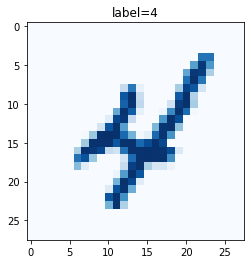

In [ ]:
#切换文件夹
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/pytorch')
#测试一下数据集类
mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

#绘制图像，看是否正常显示
mnist_dataset.plot_image(9)

#检查索引是否有效,应该看到它返回标签、像素值和目标张量
mnist_dataset[9]

#### **构建并训练神经网络类：**
*当创建神经网络类时，我们需要继承PyTorch的torch.nn模块。这样一来，新的神经网络就具备了许多PyTorch的功能，如自动构建计算图、查看权重以及在训练期间更新权重等*

In [ ]:
# 开始构建神经网络类
class Classifier(nn.Module):

  def __init__(self):
    # 初始化PyTorch父类
    super().__init__()  #super()._init__()语句调用了父类的初始化函数
    
    '''设计神经网络的结构'''
    # 定义神经网络层
    self.model = nn.Sequential(
        nn.Linear(784,200),   #1、2层间的权重
        nn.Sigmoid(),      #中间层激活函数
        nn.Linear(200,10),    #2、3层权重
        nn.Sigmoid()       #输出层激活函数
    )

    #创建损失函数(均方误差)
    #均方误差先计算每个输出节点的实际输出和预期输出之差的平方，再计算平均值
    self.loss_function = nn.BCELoss()

    #创建优化器(用于更新权重),采用简单的梯度下降法,学习率0.01
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
    '''
      在上面的代码中，我们把所有可学习参数都传递给SGD优化器。这些参数可
    以通过self.parameters()访问，这也是PyTorch提供的功能之一
    '''

    # 每完成10个训练样本之后保留一份损失副本
    # 记录训练进展的计数器和列表
    self.counter = 0
    self.progress = []

    pass


  #PyTorch假定通过一个forward()方法向网络传递信息,（提供输入，返回网络的输出）
  def forward(self,inputs):
    #直接运行模型
    return self.model(inputs)
  '''
    这里，我们只将输入传递给self.model()，它由nn.Sequential()定义。模型的输
  出直接返回给forward()的主调函数。
  '''


  #为了代码的整洁，我们选择与forward()保持一致，创建一个train()函数
  #train()既需要网络的输入值，也需要预期的目标值。这样才可以与实际输出进行比较，并计算损失值
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)

    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      #item()函数只是为了方便展开一个单值张量，获取里面的数字
      pass
    
    #每10000次训练后打印计数器的值，这样可以了解训练进展的快慢。
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass


    # 使用损失来更新网络的链接权重
    # 梯度归零，反向传播，并更新权重  (求极值？)
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
      
    
  #将训练时保存的的损失副本绘制成图,创建plot_progress函数
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True,yticks=(0,0.25,0.5))
    pass

  pass

In [ ]:
%%time 
# 顶部添加%%time，用于记录一个Python笔记本单元格运行所需时间

C = Classifier()

# 使用 MNIST数据集训练网络
# 训练4个周期
epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 5min 20s, sys: 3.07 s, total: 5min 23s
Wall time: 5min 24s


#### 测试神经网络

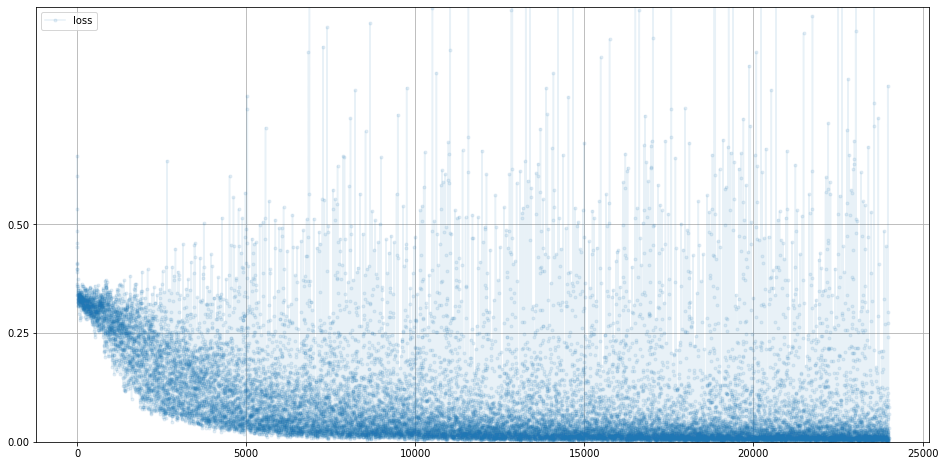

In [ ]:
C.plot_progress()

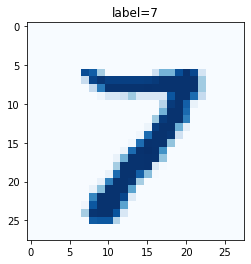

In [ ]:
# 神经网络训练完成，可以进行测试了,下面直接利用测试数据来绘图

# 加载MNIST测试数据
mnist_test_dataset = MnistDataset('mnist_data/mnist_test.csv')

# 任选一幅图像，这里选择第二十幅图
record = 34

#绘制图像和标签
mnist_test_dataset.plot_image(record)

output =  tensor([2.7270e-04, 1.6468e-04, 7.2394e-02, 1.4428e-02, 1.1876e-04, 1.2494e-04,
        1.8138e-07, 9.5795e-01, 1.1791e-03, 2.6495e-02],
       grad_fn=<SigmoidBackward0>) 



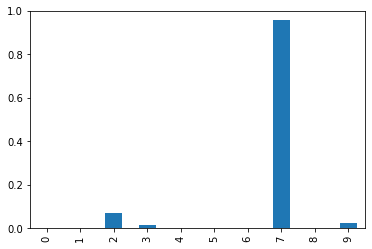

In [ ]:
#验证神经网络的判别效果，提取归一化后的像素值为神经网络的输入
image_data = mnist_test_dataset[record][1]

#调用训练后的神经网络
output = C.forward(image_data)
print("output = ", output, "\n")

#绘制输出张量,这里输出被转换成一个简单的numpy数组，再被包装成一个DataFrame，以便绘制柱形图。
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))


#10条柱形分别对应10个神经网络输出节点的值。最大值对应节点4，也就是说我们的网络认为图像是4。

#### 简易分类器的性能

In [ ]:
'''
    要知道我们的神经网络对图像分类的表现如何，一种直接的方法是对MNIST
  测试数据集中所有10000幅图像进行分类，并记录正确分类的样本数。
    分类是否正确可以通过比较网络输出和图像的标签来分辨。
'''

# 测试用训练数据训练后的网络
score = 0     #分类正确有几项
items = 0     #总共有几项

# tips:对张量执行 .detach().numpy() 即可转换为一般的numpy数组
for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  # argmax(a，axis)返回axis轴方向最大值的索引，a为数组'
  '比较网络输出和图像标签'
  if(answer.argmax() == label):
    score += 1
    pass
  items += 1
  pass

print(score, items, score/items)

9101 10000 0.9101


**可以看出，测试数据集的性能得分（准确率）从87%提高到了91%。**

**我们可以看到，损失值的确在下降，不过下降的速度比MSELoss()慢。损失值的噪声也更大，以至于在训练的后期偶尔也有较高的损失值出现。
虽然损失图看起来比之前要糟糕一些，但是在训练结束时，大部分损失值都
更低，性能得分也更高。**

## 1.3.2激活函数
  *(1)S型逻辑函数在神经网络发展的早期被广泛使用，因为它的形状看起来比较符合自然界中的实际情况。科学家们普遍认为，动物的神经元之间在传递信号时，也存在一个类似的阈值。此外，也因为在数学上它的梯度较容易计算。然而，它具有一些缺点。最主要的一个缺点是，在输入值变大时，梯度会变得非常小甚至消失。这意味着，在训练神经网络时，如果发生这种饱和（saturation），我们无法通过梯度来更新链接权重。*

  *(2)其他可选的激活函数有许多。一个简单的解决方案是使用直线作为激活函数，而直线的固定梯度是永远不会消失的。这个激活函数被称为线性整流函数（rectified linear unit）。*
  
   <b>在PyTorch中被定义为ReLU()函数。</b>

  *(3)实际上，如果所有负值的斜率都是0，小于0的输入部分同样存在梯度消失的问题。一个简单的改良是在函数的左半边增加一个小梯度，这被称为带泄漏线性整流函数（Leaky ReLU）。*

  **<u>让我们将损失函数重置为MSELoss()，并将激活函数改为LeakyReLU（0.02），其中0.02是函数左半边的梯度。</u>**

### **更改激活函数后的神经网络**


#### **代码顺序：**
*(1)创建Mnist数据集类*

*(2)测试Mnist数据集类*

*(3)创建Classifier神经网络类*

*(4)测试Classifier神经网络类*

#### **神经网络结构:**
*输入层28x28=784个节点*

*中间层 200层（随便定）*

*输出层，由于一个数字可能为0-9，因此直接为每一种可能设一个节点，即10个节点*

*激活函数采用sigmoid函数*

#### **导包：**

In [ ]:
#导包
import torch

import torch.nn as nn 
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

#### **构建并测试MNIST数据集类：**

In [ ]:
# MNIST数据集类
'''
为了学习PyTorch，我们应该
尝试以PyTorch的方式加载和使用数据
'''

class MnistDataset(Dataset):
  
  def __init__(self,csv_file):
    self.data_df = pandas.read_csv(csv_file,header=None)
    pass
  

  #__len__()方法:允许PyTorch通过len(mnist_dataset)获取数据集的大小
  def __len__(self):
    return len(self.data_df) 


  #__getitem__():允许我们通过索引获取项目，例如使用mnist_dataset[3]访问第4项
  #该函数返回值作为(类的默认返回值)
  def __getitem__(self,index):
    # 目标图像（标签）
    label = self.data_df.iloc[index,0]  #label为第index行第1列
    target = torch.zeros((10))      #创建target:维度为10的张量
    target[label] = 1.0         #target只有标签项为1,其余为0(one-hot编码)

    # 图像数据，取值范围是0-255，标准化后为0-1
    image_values = torch.FloatTensor(self.data_df.iloc
                     [index,1:].values)/255.0
    
    #返回标签、图像数据张量及目标张量
    return label,image_values,target

  
  #为MnistDataset类添加一个制图方法,绘制第index+1幅图像
  def plot_image(self,index):
    #图像数据转化为28x28数组
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    #标签作为图像标题
    plt.title("label=" + str(self.data_df.iloc[index,0]))
    plt.imshow(img,interpolation='none',cmap='Blues')
    # plt.show()   #用于去除imshow结果中的格式，只显示图像

In [ ]:
#切换文件夹
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/pytorch')
#测试一下数据集类
mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

#绘制图像，看是否正常显示
mnist_dataset.plot_image(9)

#检查索引是否有效,应该看到它返回标签、像素值和目标张量
mnist_dataset[9]

#### **构建并训练神经网络类：**
*当创建神经网络类时，我们需要继承PyTorch的torch.nn模块。这样一来，新的神经网络就具备了许多PyTorch的功能，如自动构建计算图、查看权重以及在训练期间更新权重等*

In [ ]:
# 开始构建神经网络类
class Classifier(nn.Module):

  def __init__(self):
    # 初始化PyTorch父类
    super().__init__()  #super()._init__()语句调用了父类的初始化函数
    
    '''设计神经网络的结构'''
    # 定义神经网络层
    self.model = nn.Sequential(
        nn.Linear(784,200),   #1、2层间的权重
        nn.LeakyReLU(0.02),   #中间层激活函数
        nn.Linear(200,10),    #2、3层权重
        nn.LeakyReLU(0.02)    #输出层激活函数
    )

    #创建损失函数(均方误差)
    #均方误差先计算每个输出节点的实际输出和预期输出之差的平方，再计算平均值
    self.loss_function = nn.MSELoss()

    #创建优化器(用于更新权重),采用简单的梯度下降法,学习率0.01
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
    '''
      在上面的代码中，我们把所有可学习参数都传递给SGD优化器。这些参数可
    以通过self.parameters()访问，这也是PyTorch提供的功能之一
    '''

    # 每完成10个训练样本之后保留一份损失副本
    # 记录训练进展的计数器和列表
    self.counter = 0
    self.progress = []

    pass


  #PyTorch假定通过一个forward()方法向网络传递信息,（提供输入，返回网络的输出）
  def forward(self,inputs):
    #直接运行模型
    return self.model(inputs)
  '''
    这里，我们只将输入传递给self.model()，它由nn.Sequential()定义。模型的输
  出直接返回给forward()的主调函数。
  '''


  #为了代码的整洁，我们选择与forward()保持一致，创建一个train()函数
  #train()既需要网络的输入值，也需要预期的目标值。这样才可以与实际输出进行比较，并计算损失值
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)

    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      #item()函数只是为了方便展开一个单值张量，获取里面的数字
      pass
    
    #每10000次训练后打印计数器的值，这样可以了解训练进展的快慢。
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass


    # 使用损失来更新网络的链接权重
    # 梯度归零，反向传播，并更新权重  (求极值？)
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
      
    
  #将训练时保存的的损失副本绘制成图,创建plot_progress函数
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True,yticks=(0,0.25,0.5))
    pass

  pass

In [ ]:
%%time 
# 顶部添加%%time，用于记录一个Python笔记本单元格运行所需时间

C = Classifier()

# 使用 MNIST数据集训练网络
# 训练4个周期
epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 4min 58s, sys: 3.24 s, total: 5min 1s
Wall time: 5min 7s


#### 测试神经网络

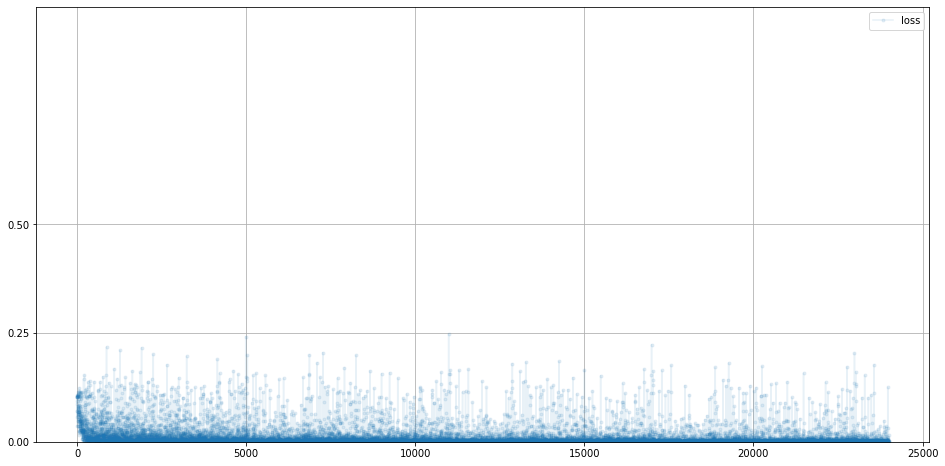

In [ ]:
C.plot_progress()

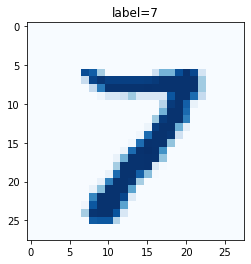

In [ ]:
# 神经网络训练完成，可以进行测试了,下面直接利用测试数据来绘图

# 加载MNIST测试数据
mnist_test_dataset = MnistDataset('mnist_data/mnist_test.csv')

# 任选一幅图像，这里选择第二十幅图
record = 34

#绘制图像和标签
mnist_test_dataset.plot_image(record)

output =  tensor([-0.0120, -0.0175, -0.0109, -0.0016, -0.0245, -0.0214, -0.0327,  0.9695,
        -0.0042, -0.0132], grad_fn=<LeakyReluBackward0>) 



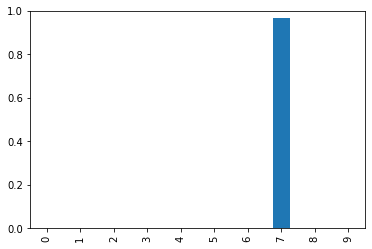

In [ ]:
#验证神经网络的判别效果，提取归一化后的像素值为神经网络的输入
image_data = mnist_test_dataset[record][1]

#调用训练后的神经网络
output = C.forward(image_data)
print("output = ", output, "\n")

#绘制输出张量,这里输出被转换成一个简单的numpy数组，再被包装成一个DataFrame，以便绘制柱形图。
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))


#10条柱形分别对应10个神经网络输出节点的值。最大值对应节点4，也就是说我们的网络认为图像是4。

#### 简易分类器的性能

In [ ]:
'''
    要知道我们的神经网络对图像分类的表现如何，一种直接的方法是对MNIST
  测试数据集中所有10000幅图像进行分类，并记录正确分类的样本数。
    分类是否正确可以通过比较网络输出和图像的标签来分辨。
'''

# 测试用训练数据训练后的网络
score = 0     #分类正确有几项
items = 0     #总共有几项

# tips:对张量执行 .detach().numpy() 即可转换为一般的numpy数组
for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  # argmax(a，axis)返回axis轴方向最大值的索引，a为数组'
  '比较网络输出和图像标签'
  if(answer.argmax() == label):
    score += 1
    pass
  items += 1
  pass

print(score, items, score/items)

9718 10000 0.9718


**重新训练网络4个周期。以我的模型来说，在测试数据集的准确率现在达到
了97%。从之前的87%到现在的97%是一个巨大的飞跃，已经非常接近使用更复
杂网络的工业级纪录。**

**<u>从图中可见，损失值从一开始就迅速下降到接近于0。即使在训练初期，平均损失值就很低，同时噪声也较少。</u>**

## 1.3.3改良方法（更改优化算法）
  *(1)随机梯度下降法的缺点之一是，它会陷入损失函数的局部最小值 （localminima）。另一个缺点是，它对所有可学习的参数都使用单一的学习率。*
  
  *(2)可替代的方案有许多，其中最常见的是Adam。它直接解决了以上两个缺点首先，它利用动量 （momentum）的概念，减少陷入局部最小值的可能性。我们
可以想象一下，一个沉重的球如何利用动量滚过一个小坑。同时，它对每个可学习参数使用单独的学习率，这些学习率随着每个参数在训练期间的变化而改变。*</u>

<b><u>复制之前的笔记本，仅将优化器从SGD改为Adam。</u></b>


### **修改优化器后的神经网络**


#### **代码顺序：**
*(1)创建Mnist数据集类*

*(2)测试Mnist数据集类*

*(3)创建Classifier神经网络类*

*(4)测试Classifier神经网络类*

#### **神经网络结构:**
*输入层28x28=784个节点*

*中间层 200层（随便定）*

*输出层，由于一个数字可能为0-9，因此直接为每一种可能设一个节点，即10个节点*

*激活函数采用sigmoid函数*

#### **导包：**

In [22]:
#导包
import torch

import torch.nn as nn 
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

#### **构建并测试MNIST数据集类：**

In [23]:
# MNIST数据集类
'''
为了学习PyTorch，我们应该
尝试以PyTorch的方式加载和使用数据
'''

class MnistDataset(Dataset):
  
  def __init__(self,csv_file):
    self.data_df = pandas.read_csv(csv_file,header=None)
    pass
  

  #__len__()方法:允许PyTorch通过len(mnist_dataset)获取数据集的大小
  def __len__(self):
    return len(self.data_df) 


  #__getitem__():允许我们通过索引获取项目，例如使用mnist_dataset[3]访问第4项
  #该函数返回值作为(类的默认返回值)
  def __getitem__(self,index):
    # 目标图像（标签）
    label = self.data_df.iloc[index,0]  #label为第index行第1列
    target = torch.zeros((10))      #创建target:维度为10的张量
    target[label] = 1.0         #target只有标签项为1,其余为0(one-hot编码)

    # 图像数据，取值范围是0-255，标准化后为0-1
    image_values = torch.FloatTensor(self.data_df.iloc
                     [index,1:].values)/255.0
    
    #返回标签、图像数据张量及目标张量
    return label,image_values,target

  
  #为MnistDataset类添加一个制图方法,绘制第index+1幅图像
  def plot_image(self,index):
    #图像数据转化为28x28数组
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    #标签作为图像标题
    plt.title("label=" + str(self.data_df.iloc[index,0]))
    plt.imshow(img,interpolation='none',cmap='Blues')
    # plt.show()   #用于去除imshow结果中的格式，只显示图像

(4,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

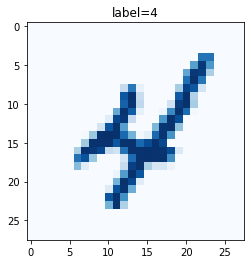

In [24]:
#切换文件夹
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/pytorch')
#测试一下数据集类
mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

#绘制图像，看是否正常显示
mnist_dataset.plot_image(9)

#检查索引是否有效,应该看到它返回标签、像素值和目标张量
mnist_dataset[9]

#### **构建并训练神经网络类：**
*当创建神经网络类时，我们需要继承PyTorch的torch.nn模块。这样一来，新的神经网络就具备了许多PyTorch的功能，如自动构建计算图、查看权重以及在训练期间更新权重等*

In [25]:
# 开始构建神经网络类
class Classifier(nn.Module):

  def __init__(self):
    # 初始化PyTorch父类
    super().__init__()  #super()._init__()语句调用了父类的初始化函数
    
    '''设计神经网络的结构'''
    # 定义神经网络层
    self.model = nn.Sequential(
        nn.Linear(784,200),   #1、2层间的权重
        nn.Sigmoid(),   #中间层激活函数
        nn.Linear(200,10),    #2、3层权重
        nn.Sigmoid()    #输出层激活函数
    )

    #创建损失函数(均方误差)
    #均方误差先计算每个输出节点的实际输出和预期输出之差的平方，再计算平均值
    self.loss_function = nn.MSELoss()

    #创建优化器(用于更新权重),采用简单的梯度下降法,学习率0.01
    self.optimiser = torch.optim.Adam(self.parameters())
    '''
      在上面的代码中，我们把所有可学习参数都传递给SGD优化器。这些参数可
    以通过self.parameters()访问，这也是PyTorch提供的功能之一
    '''

    # 每完成10个训练样本之后保留一份损失副本
    # 记录训练进展的计数器和列表
    self.counter = 0
    self.progress = []

    pass


  #PyTorch假定通过一个forward()方法向网络传递信息,（提供输入，返回网络的输出）
  def forward(self,inputs):
    #直接运行模型
    return self.model(inputs)
  '''
    这里，我们只将输入传递给self.model()，它由nn.Sequential()定义。模型的输
  出直接返回给forward()的主调函数。
  '''


  #为了代码的整洁，我们选择与forward()保持一致，创建一个train()函数
  #train()既需要网络的输入值，也需要预期的目标值。这样才可以与实际输出进行比较，并计算损失值
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)

    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      #item()函数只是为了方便展开一个单值张量，获取里面的数字
      pass
    
    #每10000次训练后打印计数器的值，这样可以了解训练进展的快慢。
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass


    # 使用损失来更新网络的链接权重
    # 梯度归零，反向传播，并更新权重  (求极值？)
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
      
    
  #将训练时保存的的损失副本绘制成图,创建plot_progress函数
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True,yticks=(0,0.25,0.5))
    pass

  pass

In [26]:
%%time 
# 顶部添加%%time，用于记录一个Python笔记本单元格运行所需时间

C = Classifier()

# 使用 MNIST数据集训练网络
# 训练4个周期
epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 18min 41s, sys: 15.2 s, total: 18min 56s
Wall time: 18min 57s


#### 测试神经网络

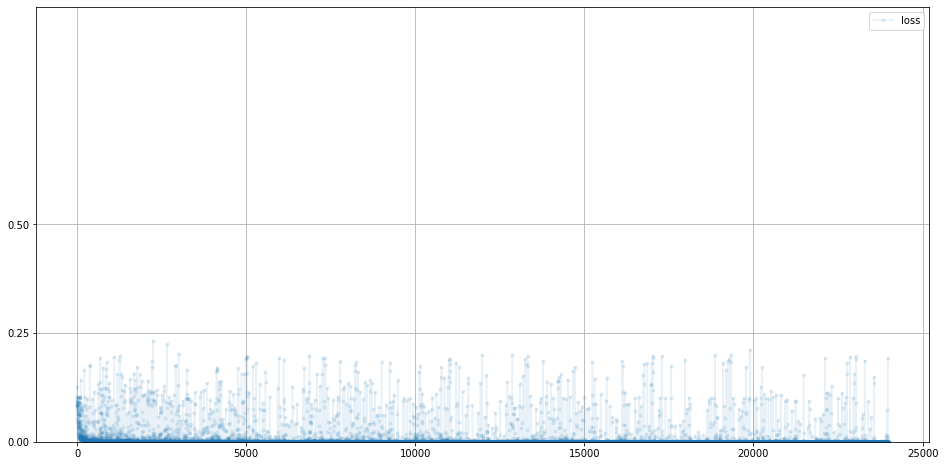

In [27]:
C.plot_progress()

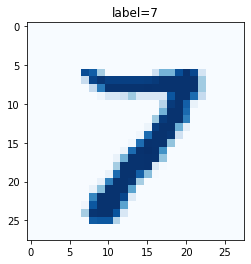

In [28]:
# 神经网络训练完成，可以进行测试了,下面直接利用测试数据来绘图

# 加载MNIST测试数据
mnist_test_dataset = MnistDataset('mnist_data/mnist_test.csv')

# 任选一幅图像，这里选择第二十幅图
record = 34

#绘制图像和标签
mnist_test_dataset.plot_image(record)

output =  tensor([1.2567e-08, 4.9630e-08, 3.8055e-05, 1.7722e-04, 1.0963e-07, 2.1694e-09,
        1.5743e-13, 9.9989e-01, 4.0004e-08, 1.5399e-06],
       grad_fn=<SigmoidBackward0>) 



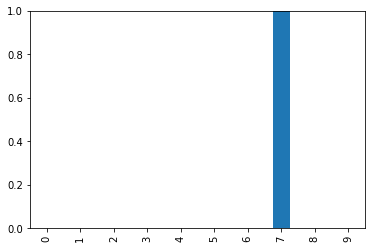

In [29]:
#验证神经网络的判别效果，提取归一化后的像素值为神经网络的输入
image_data = mnist_test_dataset[record][1]

#调用训练后的神经网络
output = C.forward(image_data)
print("output = ", output, "\n")

#绘制输出张量,这里输出被转换成一个简单的numpy数组，再被包装成一个DataFrame，以便绘制柱形图。
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))


#10条柱形分别对应10个神经网络输出节点的值。最大值对应节点4，也就是说我们的网络认为图像是4。

#### 简易分类器的性能

In [30]:
'''
    要知道我们的神经网络对图像分类的表现如何，一种直接的方法是对MNIST
  测试数据集中所有10000幅图像进行分类，并记录正确分类的样本数。
    分类是否正确可以通过比较网络输出和图像的标签来分辨。
'''

# 测试用训练数据训练后的网络
score = 0     #分类正确有几项
items = 0     #总共有几项

# tips:对张量执行 .detach().numpy() 即可转换为一般的numpy数组
for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  # argmax(a，axis)返回axis轴方向最大值的索引，a为数组'
  '比较网络输出和图像标签'
  if(answer.argmax() == label):
    score += 1
    pass
  items += 1
  pass

print(score, items, score/items)

9727 10000 0.9727


**再以4个周期来训练网络。对我的模型来说，在测试集的准确率再次达到了97%左右。与87%相比，这同样是一个巨大的进步，与使用Leaky ReLU激活函数的效果一样。**

**损失值迅速降至0左右，且均值始终保持较低(<u>相较第二节更低</u>)。看起来Adam优化器真的非常有效。**

## 1.3.4 标准化
*(1)神经网络中的权重和信号（向网络输入的数据）的取值范围都很大。之前，我们看到较大的输入值会导致饱和，使学习变得困难。大量研究表明，减少神经网络中参数和信号的取值范围，以及将均值转换为0，是有好处的。我们称这种方法为标准化 （normalization）。*

*<b><u>(2)一种常见的做法是，在信号进入一个神经网络层之前将它标准化。</u></b>*

*(3)让我们把代码重置回使用MSELoss、S型激活函数以及SGD优化器。现在，在网络信号输入最终层之前使用LayerNorm（200），将它们标准化。*

### **标准化后的神经网络**


#### **代码顺序：**
*(1)创建Mnist数据集类*

*(2)测试Mnist数据集类*

*(3)创建Classifier神经网络类*

*(4)测试Classifier神经网络类*

#### **神经网络结构:**
*输入层28x28=784个节点*

*中间层 200层（随便定）*

*输出层，由于一个数字可能为0-9，因此直接为每一种可能设一个节点，即10个节点*

*激活函数采用sigmoid函数*

#### **导包：**

In [35]:
#导包
import torch

import torch.nn as nn 
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

#### **构建并测试MNIST数据集类：**

In [36]:
# MNIST数据集类
'''
为了学习PyTorch，我们应该
尝试以PyTorch的方式加载和使用数据
'''

class MnistDataset(Dataset):
  
  def __init__(self,csv_file):
    self.data_df = pandas.read_csv(csv_file,header=None)
    pass
  

  #__len__()方法:允许PyTorch通过len(mnist_dataset)获取数据集的大小
  def __len__(self):
    return len(self.data_df) 


  #__getitem__():允许我们通过索引获取项目，例如使用mnist_dataset[3]访问第4项
  #该函数返回值作为(类的默认返回值)
  def __getitem__(self,index):
    # 目标图像（标签）
    label = self.data_df.iloc[index,0]  #label为第index行第1列
    target = torch.zeros((10))      #创建target:维度为10的张量
    target[label] = 1.0         #target只有标签项为1,其余为0(one-hot编码)

    # 图像数据，取值范围是0-255，标准化后为0-1
    image_values = torch.FloatTensor(self.data_df.iloc
                     [index,1:].values)/255.0
    
    #返回标签、图像数据张量及目标张量
    return label,image_values,target

  
  #为MnistDataset类添加一个制图方法,绘制第index+1幅图像
  def plot_image(self,index):
    #图像数据转化为28x28数组
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    #标签作为图像标题
    plt.title("label=" + str(self.data_df.iloc[index,0]))
    plt.imshow(img,interpolation='none',cmap='Blues')
    # plt.show()   #用于去除imshow结果中的格式，只显示图像

(4,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

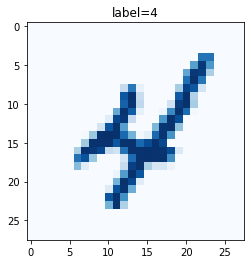

In [37]:
#切换文件夹
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/pytorch')
#测试一下数据集类
mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

#绘制图像，看是否正常显示
mnist_dataset.plot_image(9)

#检查索引是否有效,应该看到它返回标签、像素值和目标张量
mnist_dataset[9]

#### **构建并训练神经网络类：**
*当创建神经网络类时，我们需要继承PyTorch的torch.nn模块。这样一来，新的神经网络就具备了许多PyTorch的功能，如自动构建计算图、查看权重以及在训练期间更新权重等*

In [38]:
# 开始构建神经网络类
class Classifier(nn.Module):

  def __init__(self):
    # 初始化PyTorch父类
    super().__init__()  #super()._init__()语句调用了父类的初始化函数
    
    '''设计神经网络的结构'''
    # 定义神经网络层
    self.model = nn.Sequential(
        nn.Linear(784,200),   #1、2层间的权重
        nn.Sigmoid(),      #中间层激活函数

        nn.LayerNorm(200),

        nn.Linear(200,10),    #2、3层权重
        nn.Sigmoid()       #输出层激活函数
    )

    #创建损失函数(均方误差)
    #均方误差先计算每个输出节点的实际输出和预期输出之差的平方，再计算平均值
    self.loss_function = nn.MSELoss()

    #创建优化器(用于更新权重),采用简单的梯度下降法,学习率0.01
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
    '''
      在上面的代码中，我们把所有可学习参数都传递给SGD优化器。这些参数可
    以通过self.parameters()访问，这也是PyTorch提供的功能之一
    '''

    # 每完成10个训练样本之后保留一份损失副本
    # 记录训练进展的计数器和列表
    self.counter = 0
    self.progress = []

    pass


  #PyTorch假定通过一个forward()方法向网络传递信息,（提供输入，返回网络的输出）
  def forward(self,inputs):
    #直接运行模型
    return self.model(inputs)
  '''
    这里，我们只将输入传递给self.model()，它由nn.Sequential()定义。模型的输
  出直接返回给forward()的主调函数。
  '''


  #为了代码的整洁，我们选择与forward()保持一致，创建一个train()函数
  #train()既需要网络的输入值，也需要预期的目标值。这样才可以与实际输出进行比较，并计算损失值
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)

    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      #item()函数只是为了方便展开一个单值张量，获取里面的数字
      pass
    
    #每10000次训练后打印计数器的值，这样可以了解训练进展的快慢。
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass


    # 使用损失来更新网络的链接权重
    # 梯度归零，反向传播，并更新权重  (求极值？)
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
      
    
  #将训练时保存的的损失副本绘制成图,创建plot_progress函数
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True,yticks=(0,0.25,0.5))
    pass

  pass

In [39]:
%%time 
# 顶部添加%%time，用于记录一个Python笔记本单元格运行所需时间

C = Classifier()

# 使用 MNIST数据集训练网络
# 训练4个周期
epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 5min 37s, sys: 4.17 s, total: 5min 42s
Wall time: 5min 47s


#### 测试神经网络

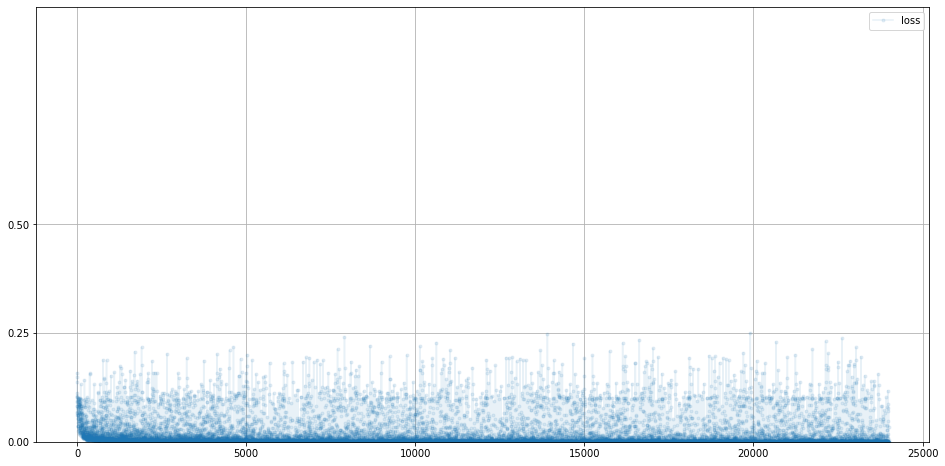

In [40]:
C.plot_progress()

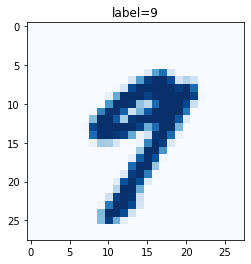

In [49]:
# 神经网络训练完成，可以进行测试了,下面直接利用测试数据来绘图

# 加载MNIST测试数据
mnist_test_dataset = MnistDataset('mnist_data/mnist_test.csv')

# 任选一幅图像，这里选择第9幅图  （9和4容易搞混，这样更方便检验性能）
record = 20

#绘制图像和标签
mnist_test_dataset.plot_image(record)

output =  tensor([4.5959e-04, 2.8552e-04, 1.5454e-08, 1.7490e-02, 2.1217e-02, 3.6533e-05,
        1.6266e-06, 1.0066e-01, 1.2732e-02, 9.3602e-01],
       grad_fn=<SigmoidBackward0>) 



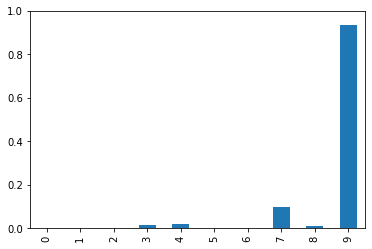

In [50]:
#验证神经网络的判别效果，提取归一化后的像素值为神经网络的输入
image_data = mnist_test_dataset[record][1]

#调用训练后的神经网络
output = C.forward(image_data)
print("output = ", output, "\n")

#绘制输出张量,这里输出被转换成一个简单的numpy数组，再被包装成一个DataFrame，以便绘制柱形图。
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))


#10条柱形分别对应10个神经网络输出节点的值。最大值对应节点4，也就是说我们的网络认为图像是4。

#### 简易分类器的性能

In [51]:
'''
    要知道我们的神经网络对图像分类的表现如何，一种直接的方法是对MNIST
  测试数据集中所有10000幅图像进行分类，并记录正确分类的样本数。
    分类是否正确可以通过比较网络输出和图像的标签来分辨。
'''

# 测试用训练数据训练后的网络
score = 0     #分类正确有几项
items = 0     #总共有几项

# tips:对张量执行 .detach().numpy() 即可转换为一般的numpy数组
for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  # argmax(a，axis)返回axis轴方向最大值的索引，a为数组'
  '比较网络输出和图像标签'
  if(answer.argmax() == label):
    score += 1
    pass
  items += 1
  pass

print(score, items, score/items)

9136 10000 0.9136


**在训练3个周期之后，模型在测试数据集的准确率是91%，相比原始网络的87%有所进步。**

**可以看出，损失值下降的速率要高于原始网络。如果我们考虑噪声在图中的密度，而不只是高度，则损失值的噪声也较少。同样地，网络输出也更加明确，判断为4的置信度非常高。同时，对9的预测仍有一小部分，这也不难理解。与原始网络不同的是，其他数字的预测值都是0。**

## 1.3.5整合改良方法

<b><u>(1)让我们把以上的改良方法整合到一起，包括BCE损失、Leaky ReLU激活函数、Adam优化器以及分层标准化。
</u></b>

*(2)由于BCE只能处理0～1的值，而Leaky ReLU则有可能输出范围之外的值，我们在最终层之后保留一个S型函数，但是在隐藏层之后使用LeakyReLU。*

## **2.整合上述所有改良方法后的神经网络**


#### **代码顺序：**
*(1)创建Mnist数据集类*

*(2)测试Mnist数据集类*

*(3)创建Classifier神经网络类*

*(4)测试Classifier神经网络类*

#### **神经网络结构:**
*输入层28x28=784个节点*

*中间层 200层（随便定）*

*输出层，由于一个数字可能为0-9，因此直接为每一种可能设一个节点，即10个节点*

*激活函数采用sigmoid函数*

#### **导包：**

In [52]:
#导包
import torch

import torch.nn as nn 
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

#### **构建并测试MNIST数据集类：**

In [53]:
# MNIST数据集类
'''
为了学习PyTorch，我们应该
尝试以PyTorch的方式加载和使用数据
'''

class MnistDataset(Dataset):
  
  def __init__(self,csv_file):
    self.data_df = pandas.read_csv(csv_file,header=None)
    pass
  

  #__len__()方法:允许PyTorch通过len(mnist_dataset)获取数据集的大小
  def __len__(self):
    return len(self.data_df) 


  #__getitem__():允许我们通过索引获取项目，例如使用mnist_dataset[3]访问第4项
  #该函数返回值作为(类的默认返回值)
  def __getitem__(self,index):
    # 目标图像（标签）
    label = self.data_df.iloc[index,0]  #label为第index行第1列
    target = torch.zeros((10))      #创建target:维度为10的张量
    target[label] = 1.0         #target只有标签项为1,其余为0(one-hot编码)

    # 图像数据，取值范围是0-255，标准化后为0-1
    image_values = torch.FloatTensor(self.data_df.iloc
                     [index,1:].values)/255.0
    
    #返回标签、图像数据张量及目标张量
    return label,image_values,target

  
  #为MnistDataset类添加一个制图方法,绘制第index+1幅图像
  def plot_image(self,index):
    #图像数据转化为28x28数组
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    #标签作为图像标题
    plt.title("label=" + str(self.data_df.iloc[index,0]))
    plt.imshow(img,interpolation='none',cmap='Blues')
    # plt.show()   #用于去除imshow结果中的格式，只显示图像

(4,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

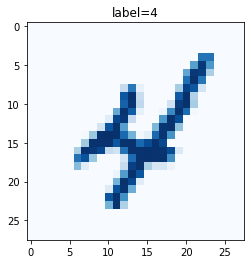

In [54]:
#切换文件夹
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/pytorch')
#测试一下数据集类
mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

#绘制图像，看是否正常显示
mnist_dataset.plot_image(9)

#检查索引是否有效,应该看到它返回标签、像素值和目标张量
mnist_dataset[9]

#### **构建并训练神经网络类：**
*当创建神经网络类时，我们需要继承PyTorch的torch.nn模块。这样一来，新的神经网络就具备了许多PyTorch的功能，如自动构建计算图、查看权重以及在训练期间更新权重等*

In [55]:
# 开始构建神经网络类
class Classifier(nn.Module):

  def __init__(self):
    # 初始化PyTorch父类
    super().__init__()  #super()._init__()语句调用了父类的初始化函数
    
    '''设计神经网络的结构'''
    # 定义神经网络层

    '''
      由于BCE只能处理0～1的值，而Leaky ReLU则有可能输出范围之外的值，我
    们在最终层之后保留一个S型函数，但是在隐藏层之后使用LeakyReLU。
    '''
    self.model = nn.Sequential(
        nn.Linear(784,200),   #1、2层间的权重
        nn.LeakyReLU(0.02),   #中间层激活函数

        nn.LayerNorm(200),

        nn.Linear(200,10),    #2、3层权重
        nn.Sigmoid()       #输出层激活函数
    )

    #创建损失函数(均方误差)
    #均方误差先计算每个输出节点的实际输出和预期输出之差的平方，再计算平均值
    self.loss_function = nn.BCELoss()

    #创建优化器(用于更新权重),采用简单的梯度下降法,学习率0.01
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
    '''
      在上面的代码中，我们把所有可学习参数都传递给SGD优化器。这些参数可
    以通过self.parameters()访问，这也是PyTorch提供的功能之一
    '''

    # 每完成10个训练样本之后保留一份损失副本
    # 记录训练进展的计数器和列表
    self.counter = 0
    self.progress = []

    pass


  #PyTorch假定通过一个forward()方法向网络传递信息,（提供输入，返回网络的输出）
  def forward(self,inputs):
    #直接运行模型
    return self.model(inputs)
  '''
    这里，我们只将输入传递给self.model()，它由nn.Sequential()定义。模型的输
  出直接返回给forward()的主调函数。
  '''


  #为了代码的整洁，我们选择与forward()保持一致，创建一个train()函数
  #train()既需要网络的输入值，也需要预期的目标值。这样才可以与实际输出进行比较，并计算损失值
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)

    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      #item()函数只是为了方便展开一个单值张量，获取里面的数字
      pass
    
    #每10000次训练后打印计数器的值，这样可以了解训练进展的快慢。
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass


    # 使用损失来更新网络的链接权重
    # 梯度归零，反向传播，并更新权重  (求极值？)
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
      
    
  #将训练时保存的的损失副本绘制成图,创建plot_progress函数
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True,yticks=(0,0.25,0.5))
    pass

  pass

In [56]:
%%time 
# 顶部添加%%time，用于记录一个Python笔记本单元格运行所需时间

C = Classifier()

# 使用 MNIST数据集训练网络
# 训练4个周期
epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 5min 34s, sys: 4 s, total: 5min 38s
Wall time: 5min 39s


#### 测试神经网络

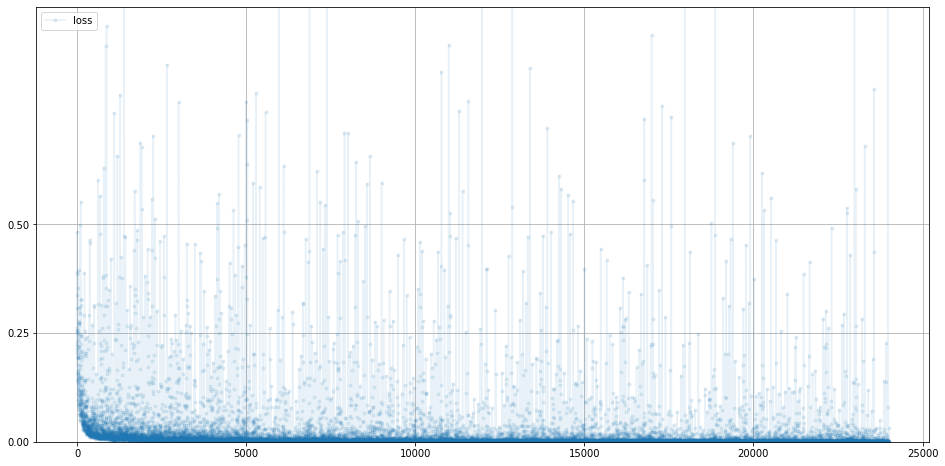

In [57]:
C.plot_progress()

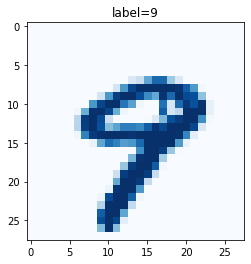

In [61]:
# 神经网络训练完成，可以进行测试了,下面直接利用测试数据来绘图

# 加载MNIST测试数据
mnist_test_dataset = MnistDataset('mnist_data/mnist_test.csv')

# 任选一幅图像，这里选择第二十幅图
record = 9

#绘制图像和标签
mnist_test_dataset.plot_image(record)

output =  tensor([9.3450e-05, 3.0623e-06, 3.8666e-05, 4.8526e-06, 8.5435e-03, 1.1189e-06,
        1.3857e-06, 2.8932e-04, 6.8900e-05, 9.9385e-01],
       grad_fn=<SigmoidBackward0>) 



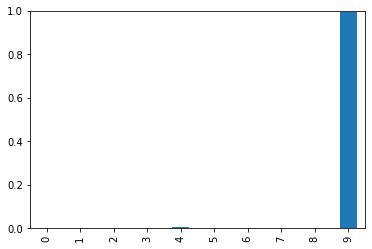

In [62]:
#验证神经网络的判别效果，提取归一化后的像素值为神经网络的输入
image_data = mnist_test_dataset[record][1]

#调用训练后的神经网络
output = C.forward(image_data)
print("output = ", output, "\n")

#绘制输出张量,这里输出被转换成一个简单的numpy数组，再被包装成一个DataFrame，以便绘制柱形图。
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))


#10条柱形分别对应10个神经网络输出节点的值。最大值对应节点4，也就是说我们的网络认为图像是4。

#### 简易分类器的性能

In [63]:
'''
    要知道我们的神经网络对图像分类的表现如何，一种直接的方法是对MNIST
  测试数据集中所有10000幅图像进行分类，并记录正确分类的样本数。
    分类是否正确可以通过比较网络输出和图像的标签来分辨。
'''

# 测试用训练数据训练后的网络
score = 0     #分类正确有几项
items = 0     #总共有几项

# tips:对张量执行 .detach().numpy() 即可转换为一般的numpy数组
for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  # argmax(a，axis)返回axis轴方向最大值的索引，a为数组'
  '比较网络输出和图像标签'
  if(answer.argmax() == label):
    score += 1
    pass
  items += 1
  pass

print(score, items, score/items)

9751 10000 0.9751


**训练3个周期之后的准确率是97%。看来整合我们的优化方案无法使准确率超过97%。要达到世界级的分数，<u>我们需要更复杂的网络架构。</u>**